In [1]:
from pathlib import Path
import numpy as np

In [2]:
outputs = [Path("slurm-"+x+".out") for x in [ 
    '274557', # 10 ny
    '274850', # 20 ny
    '274563', # 40 ny
    '274503', # 80 ny
    '274579', # 120 ny
    '274610', # 160 ny
    '278696', # 200 ny, 16 tasks per node (64 bank), shared mem prealloacted
    '277962', # 240 ny , 16 tasks per node (64 bank), shared mem prealloacted
    '277894', # 280 ny,  16 tasks per node (64 bank), shared mem prealloacted 
]]

In [3]:
def getnMPI(lines):
    nMPI = 0
    #with open(filename) as file:
    for line in lines:
        if "MPI processes" in line:
            words = line.split()
            nMPI= int(words[5])
            return nMPI

In [4]:
#note the routine will not return time of last cycle
def getnorbitals(lines):
    norbitals = 0
    newcycle = False
    for line in lines:
        if "F(i,i)" in line:
            newcycle = True
        if(newcycle):
            if "  p " in line:
                words = line.split()
                norbitals = int(words[0]) + 1

        if newcycle and ("Total residual" in line):
            return norbitals

In [5]:
#note the routine will not return time of last cycle
def getwalltimes(contents):
    ncycles = 0
    newcycle = False
    offset = 0
    wtimes = []
    
    for line in contents:
        if "cycle" in line:
            newcycle = True
            if(ncycles>0):
                wtimes.append(float(words[2]))
            ncycles+=1
        if "Wall time" in line:
            words = line.split()

    return wtimes

In [6]:
#note the routine will not return time of last cycle
def getHFtimes(contents):
    ncycles = 0
    newcycle = False
    offset = 0
    wtimes = []
    for line in contents:
        if "cycle" in line:
            newcycle = True
            if(ncycles>0):
                t = float(words[7])
                if(words[8]=="min"):
                    t *= 60
                wtimes.append(t)
            ncycles+=1

        if "HF exchange (av.)" in line:
            words = line.split()

    return wtimes

In [7]:
#note the routine will not return time of last cycle
def getTtimes(contents):
    ncycles = 0
    newcycle = False
    wtimes = []

    for line in contents:
        if "cycle" in line:
            newcycle = True
            if(ncycles>0):
                tx = float(wordsx[5])
                if(wordsx[6]=="min"):
                    tx *= 60
                ty = float(wordsy[5])
                if(wordsx[6]=="min"):
                    ty *= 60
                tz = float(wordsz[5])
                if(wordsx[6]=="min"):
                    tz *= 60
                wtimes.append(tx+ty+tz)
            ncycles+=1

        if "p[x]p[x]" in line:
             wordsx = line.split()
        if "p[y]p[y]" in line:
            wordsy = line.split()
        if "p[z]p[z]" in line:
            wordsz = line.split()

    return wtimes

In [8]:
#note the routine will not return time of last cycle
def getHtimes(contents):
    ncycles=0
    newcycle = False
    offset = -1
    Helmholtz=-1
    tot=0.0
    ta = 0.0
    wtimes=[]
    
    
    for line in contents:
        if "cycle" in line:
            newcycle = True
            if(ncycles>0):
                tr = float(wordsr[3])
                wtimes.append(tr+ta)
            ncycles+=1

        if "Applying Helmholtz operators" in line:
            Helmholtz = 1
            ta=0.0
        if(Helmholtz == 1 and ("Wall time" in line)):
            Helmholtz = 0
        if(Helmholtz == 1 and ("nds" in line)):
            words = line.split()
            t=float(words[6])
            if(words[7]=="min"):
                t*=60.0
            ta += t
        if "Computing Helmholtz argument" in line:
            offset = 2
        if (offset==0):
            wordsr = line.split()
        offset -= 1

    return wtimes

In [9]:
#note the routine will not return time of last cycle
def getCtimes(contents):
    ncycles=0
    newcycle = False
    offset=0
    tot = 0.0
    wtimes = []
    
    for line in contents:
        if "cycle" in line:
            newcycle = True
            if(ncycles>0):
                wtimes.append(tot)
            ncycles+=1
            tot=0.0
        if ("Coulomb density" in line or "Coulomb potential" in line or "Allreduce Coulomb" in line) :
            words = line.split()
            t = float(words[6])
            if(words[7]=="min"):
                t *= 60
            tot += t

    return wtimes

In [10]:
#note the routine will not return time of last cycle
def getStimes(contents):
    ncycles=0
    newcycle = False
    offset=0
    t = 0
    wtimes = []
    
    for line in contents:
        if "cycle" in line:
            newcycle = True
            if(ncycles>0):
                wtimes.append(t)
            ncycles+=1
        if ("average size" in line ) :
            words = line.split()
            t = int(words[2])


    return wtimes

In [11]:
def getenergy(contents):
    
    for line in contents:
        if "Total energy       (au) " in line:
            words = line.split()
            energy=float(words[3])
    return energy

In [12]:
from copy import deepcopy


data = []

for out in outputs:
 
    item = {
        "n_orbitals": [],
        "n_MPI": [],
        "walltime": [],
        "exchange": [],
        "kinetic": [],
        "helmholtz": [],
        "coulomb": [], 
        "S": [],
    }
    with out.open("r") as fh:
        contents = fh.readlines()
        
        item["n_MPI"].append(getnMPI(contents))
        item["n_orbitals"].append(getnorbitals(contents))
        item["walltime"].append(getwalltimes(contents))
        item["exchange"].append(getHFtimes(contents))
        item["kinetic"].append(getTtimes(contents))
        item["helmholtz"].append(getHtimes(contents))
        item["coulomb"].append(getCtimes(contents))
        item["S"].append(getStimes(contents))

    data.append(deepcopy(item))

In [13]:
# aggregate data
processed = {
    "n_orbitals" : [],
    "walltime_mean" : [],
    "walltime_stddev": [],
    "exchange_mean": [],
    "exchange_stddev": [],
    "kinetic_mean": [],
    "kinetic_stddev": [],
    "helmholtz_mean": [],
    "helmholtz_stddev": [],
    "coulomb_mean": [], 
    "coulomb_stddev": [],
    "S_mean": [],
    "S_stddev": [],
}
for item in data:
    n_orb = item["n_orbitals"]
    processed["n_orbitals"].extend(n_orb)
    for k in item.keys():
        if k != "n_orbitals" and k != "n_MPI":
            processed[f"{k}_mean"].extend(np.mean(item[k]) / n_orb)
            processed[f"{k}_stddev"].extend(np.std(item[k]) / n_orb)

In [24]:
import piplite
await piplite.install(["plotly"])

In [19]:
import plotly.graph_objects as go

In [70]:
# plot data at 5th iteration
fig = go.Figure()

labels = ["Total", "Exchange", "Kinetic", "Coulomb", "Helmholtz"]

xs = [_["n_orbitals"][0] for _ in data]

for i, v in enumerate(["walltime", "exchange", "kinetic", "coulomb", "helmholtz"]):
    # divide each timing by the number of orbitals
    ys = [_[f"{v}"][0][3] / xs[k] for k, _ in enumerate(data)]
    fig.add_trace(
        go.Scatter(
            name=labels[i],
            mode="lines+markers",
            marker_symbol=i,
            x=xs,
            y=ys,
        )
    )

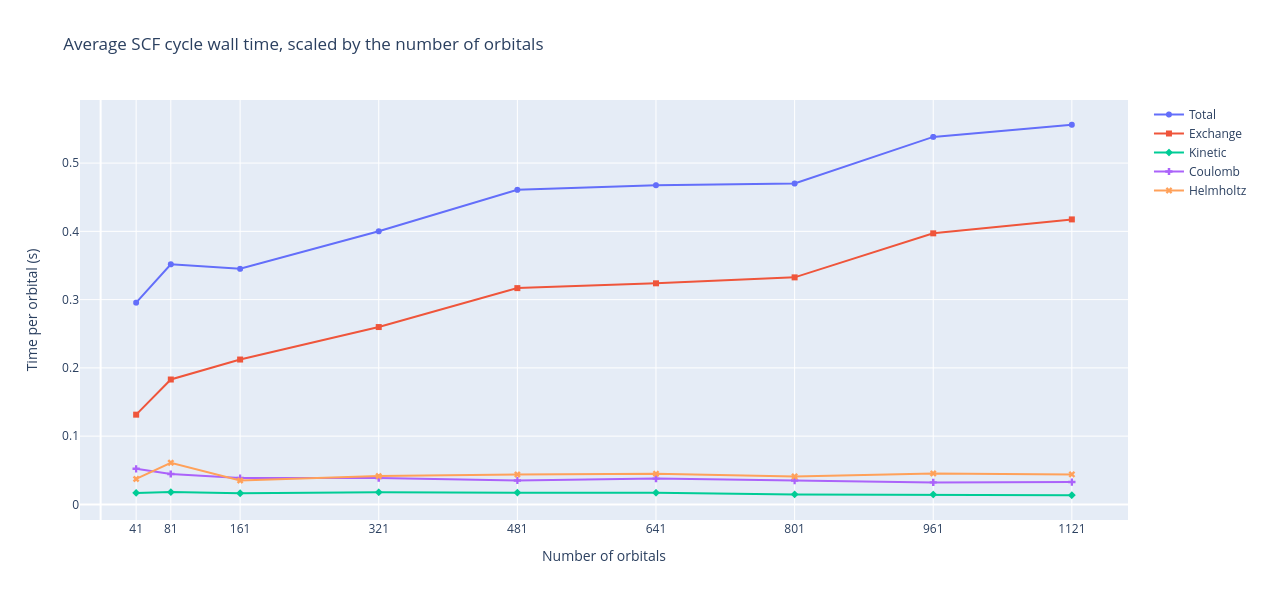

<class 'ValueError'>: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [71]:
fig.update_layout(
    title=r"Average SCF cycle wall time, scaled by the number of orbitals",
    xaxis_title="Number of orbitals",
    yaxis_title="Time per orbital (s)",
    height=600,
    width=1000,
    xaxis = dict(
        tickmode='array',
        tickvals=xs,
    ),
)

In [30]:
# plot averages with standard deviations and use log scale
fig = go.Figure()

labels = ["Total", "Exchange", "Kinetic", "Coulomb", "Helmholtz"]

for i, v in enumerate(["walltime", "exchange", "kinetic", "coulomb", "helmholtz"]):
    fig.add_trace(
        go.Scatter(
            name=labels[i],
            mode="lines+markers",
            marker_symbol=i,
            x=processed["n_orbitals"],
            y=processed[f"{v}_mean"],
            error_y=dict(
                type="data",
                array=processed[f"{v}_stddev"],
                visible=True,
            ),
        )
    )

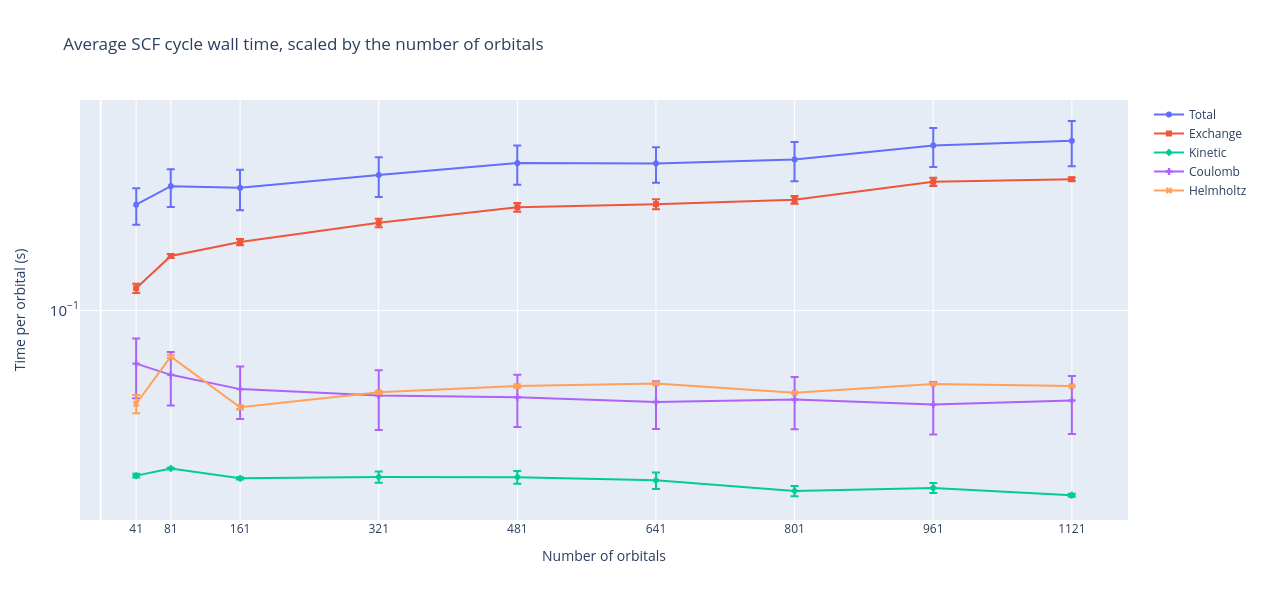

<class 'ValueError'>: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [31]:
fig.update_layout(
    hovermode="x unified",
    title=r"Average SCF cycle wall time, scaled by the number of orbitals",
    xaxis_title="Number of orbitals",
    yaxis_title="Time per orbital (s)",
    height=600,
    width=1000,
    xaxis = dict(
        tickmode='array',
        tickvals=processed["n_orbitals"],
    ),
    yaxis=dict(type="log", showexponent="all", exponentformat="power", dtick=1),
)